In [23]:
import numpy as np
import torch
import scipy
import time

import sys
sys.path.insert(1, '/home/ashish-razer/Projects/PSMs/PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/ashish-razer/Projects/PSMs/PSM_V1')
from PINNsUtil import PINN
#from pinnutils import PINNN
from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3, ProdCheby, ProdCheby2, ProdCheby_NL 

In [24]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [25]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$${\large\begin{cases}
        \Delta u + f = 0, (x,y) \in \Omega\\
        u = g, (x,y) \in \partial \Omega
    \end{cases}}$$
with:
$$
    {\large f(x,y) = 2\lambda^2 cos(\lambda x) sin(\lambda y)}\\
    {\large g(x,y) = cos(\lambda x) sin(\lambda y)}\\
    {\large \lambda = 2 \pi q}
$$

In [26]:
rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])

q = 3
lam = 2*np.pi*q

def f(x,y):
    return 2*lam**2*np.cos(lam*x)*np.sin(lam*y)

In [27]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=30, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])), dtype = torch.float32)

### Ground Truth

In [28]:
def gt(x,y):
    return np.cos(lam*x)*np.sin(lam*y)

### Gradient Flow

In [29]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [30]:
# Sobolev Order
sob_2d.set_s(0)
sob_1d_0.set_s(0)

In [31]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()
xs = torch.tensor(xs)
xs_bdx =  torch.tensor(xs_bndr_0[0])
X_t, Y_t = torch.meshgrid(xs[0],xs[1])
X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdl = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][0]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdr = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][1]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdl = torch.tensor(torch.cat((rect[0][0]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdr = torch.tensor(torch.cat((rect[0][1]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
u_bdxl = torch.tensor(gt(xs_bndr_0[0], rect[1][0].reshape(-1)), dtype = torch.float32)
u_bdxr = torch.tensor(gt(xs_bndr_0[0], rect[1][1].reshape(-1)), dtype = torch.float32)
u_bdyl= torch.tensor(gt(rect[0][0].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
u_bdyr= torch.tensor(gt(rect[0][1].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
fXY = f(X_t,Y_t).reshape(-1)
w_2d = torch.tensor(sob_2d.get_leja_weights(), dtype = torch.float32)
w_1d = torch.tensor(sob_1d_0.get_leja_weights(), dtype = torch.float32)

/tmp/ipykernel_10754/1176703409.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
/tmp/ipykernel_10754/1176703409.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_bdl = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][0]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
/tmp/ipykernel_10754/1176703409.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_bdr = torch.tens

In [32]:
#Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
K = dx2+dy2
eq = lambda u: matmul(K, u)+fXY
crit_pde = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bdxl = lambda u: sob_1d_0.l2_loss(u-u_bdxl)
crit_bdxr = lambda u: sob_1d_0.l2_loss(u-u_bdxr)
crit_bdyl = lambda u: sob_1d_0.l2_loss(u-u_bdyl)
crit_bdyr = lambda u: sob_1d_0.l2_loss(u-u_bdyr)
#grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
#grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
#grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

In [33]:
TD = np.concatenate([X_pde.detach().numpy(),X_bdl.detach().numpy(), X_bdr.detach().numpy(), Y_bdl.detach().numpy() , Y_bdl.detach().numpy()], 0)
# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True),device=device)
X_std = torch.tensor(np.std(TD, axis=0, keepdims=True),device=device)
seedc = 1

In [34]:
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)


In [35]:
def closure(optim):
        optim.zero_grad()
        loss.backward()
        return loss

In [36]:
#lam_s = torch.max(torch.linalg.eig(dx2)[0].real)
lam_s = torch.max(abs(dx2))

In [109]:
net = PINN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
net = ProdCheby_NL([2, 25, 15, 15], [7, 7, 7], 1, nn.Identity()).to(device)

In [110]:
%%time

print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
n_epochs   = 30000
lamb  = 1
losses_bc  = [];
losses_reg = [];
params = [{'params': net.parameters()}]
milestones = [[15000,25000]]
optimizer = torch.optim.Adam(params)
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
start_time = time.time()
ds = 1
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    uhat  = net(X_pde).T[0]
    #l_pde   = crit_pde(uhat)
    l_pde = torch.sum(((eq(uhat)*w_2d)**2))
    predxl = net(X_bdl).T[0]
    predxr = net(X_bdr).T[0]
    predyl = net(Y_bdl).T[0]
    predyr = net(Y_bdr).T[0]
    #l_bc = crit_bdxl(predxl) + crit_bdxr(predxr) + crit_bdyl(predyl) + crit_bdyr(predyr) 
    l_bc = torch.sum((((predxl-u_bdxl)*w_1d)**2))+torch.sum((((predxr-u_bdxr)*w_1d)**2))+torch.sum((((predyl-u_bdyl)*w_1d)**2))
    l_bc += torch.sum((((predyr-u_bdyr)*w_1d)**2))
    
    loss = l_pde/1000+ l_bc
    losses_bc.append(l_bc.item())
    losses_reg.append(l_pde.item())
    
    #loss.backward()
    optimizer.step(
                lambda: closure(
                    optimizer,
                ))
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 5470
CPU time =  487.81421661376953043865, lambda=1.0000, lr=0.00001			
CPU times: user 1h 4min 23s, sys: 39.2 s, total: 1h 5min 2s
Wall time: 8min 7s


In [111]:
X_test, Y_test = torch.meshgrid(torch.linspace(-1,1,100),torch.linspace(-1,1,100))
X_T = torch.cat((X_test.reshape(-1,1), Y_test.reshape(-1,1)),1) 

pred rel. linf-error = 2.224803e-01
pred rel. l2-error = 1.013266e-02
pred_rel_std. linf-error = 2.057207e-02


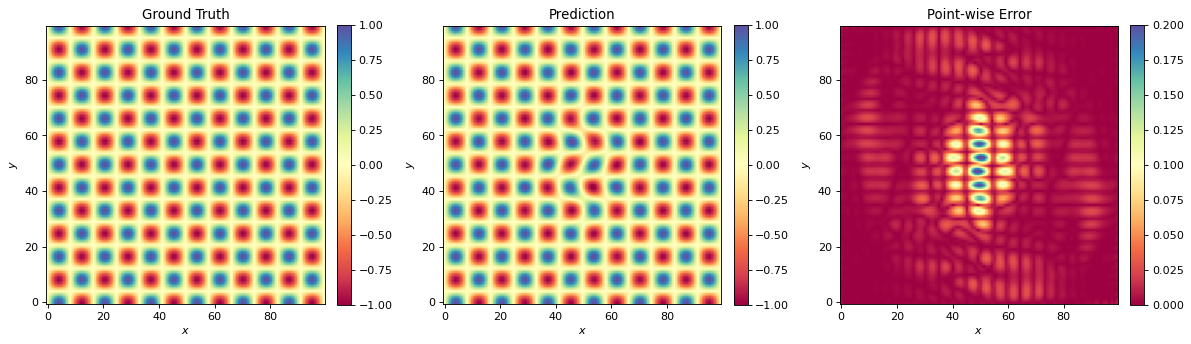

In [112]:
plt.figure(figsize=(15, 25), dpi=80)
u_sol = gt(X_test,Y_test).detach().numpy()
out = net(X_T).reshape(100,100).detach().numpy()
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
print("pred_rel_std. linf-error = {:e}".format(np.std(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.clim(0,0.2)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.gcf().set_size_inches(14,4)
plt.tight_layout()
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')

In [113]:
import pickle

f = open('store.pckl', 'wb')
pickle.dump(net(X_T), f)
f.close()

f = open('store.pckl', 'rb')
obj = pickle.load(f)
f.close()